<a href="https://colab.research.google.com/github/fshnkarimi/LungTumor-Segmentation/blob/main/LungTumorSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
# !pip install celluloid
# !pip install torch
import torch

torch.cuda.is_available()

True

In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.device_count())

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
# Inspect some sample data
root = Path("/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/imagesTr")
label = Path("/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/labelsTr")

In [5]:
print(root)

/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/imagesTr


In [6]:
# Load a sample NIfTI and its corresponding label mask

def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [7]:
sample_path = list(root.glob("lung*"))[2]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [8]:
sample_path, sample_path_label

(PosixPath('/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/imagesTr/lung_083.nii.gz'),
 PosixPath('/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/labelsTr/lung_083.nii.gz'))

In [9]:
# Load NIfTI and extract image data
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

In [10]:
# Find out the orientation
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

In [4]:
# Inspect the loaded data with overlaid Ground Truth tumor segmentation using axial view
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




<IPython.core.display.Javascript object>

NameError: name 'ct' is not defined

In [56]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


RuntimeError: Requested MovieWriter (ffmpeg) not available

## Preprocessing

1. CT images have a fixed range from -1000 to 3071. **Thus we can normalize by dividing by 3071**
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, we might skip the first 30 slices (from lower abdomen to the neck) (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost we should store the preprocessed data as 2d files, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

In the preprocessing loop, we need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

we will store the last 6 subjects as validation data


In [11]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [ ]:
len(all_files)

63

In [13]:
save_root = Path("/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label. Remove the first 30 slices  
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        

  0%|          | 0/63 [00:00<?, ?it/s]

## Validate preprocessed data
Take a look at our stored files and inspect if everything worked as expected

In [42]:
path = Path("/home/nguye/cse493/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess/train/data/lung_001_50.npy")  # Select a subject. Check the folder if it exists


In [43]:
data = np.load(path)

In [44]:
data.shape

(256, 256)

In [22]:
list(path.glob("*"))

[PosixPath('/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess/train/2/data'),
 PosixPath('/home/nguye/project/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess/train/2/masks')]

In [23]:
1# Choose a file and load slice + mask
file = "120.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

In [19]:
%matplotlib inline

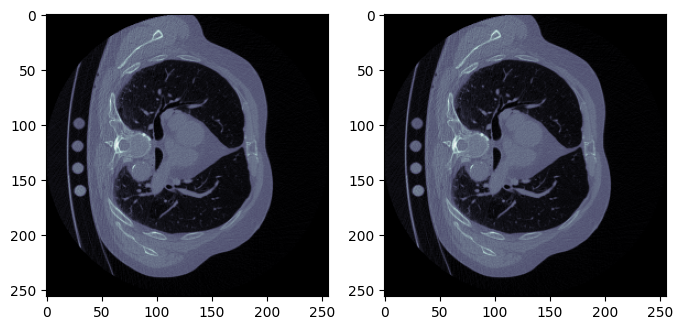

In [24]:
# Plot everything
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [25]:
print(slice.min(), slice.max())

-0.33344187561055033 0.4275480299576685


## Train

In [ ]:
!pip install pytorch_lightning

In [ ]:
# !pip uninstall imgaug
!pip install imgaug


In [2]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from celluloid import Camera
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from datasett import LungDataset
from model.baseline.model import UNet
from model.baseline.baseline_lightning import TumorSegmentation

from dataset.lungdataset import get_dataset

In [2]:
%load_ext autoreload
%autoreload 2

### Dataset Creation

In [3]:
seq = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    iaa.ElasticTransformation()  # Elastic Transformations
                ])


In [ ]:
# Create the dataset objects
train_path = Path("/home/nguye/project/LungTumor-Segmentation-main/dataset/SmallDataSet/Preprocess/train")
val_path = Path("/home/nguye/project/LungTumor-Segmentation-main/dataset/SmallDataSet/Preprocess/val")

train_dataset = LungDataset(train_path, seq)
val_dataset = LungDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

In [4]:
train_dataset = get_dataset("/home/nguye/cse493/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess", seq, "train")
val_dataset = get_dataset("/home/nguye/cse493/LungTumor-Segmentation-main/dataset/Task06_Lung/Preprocess", None, "val")

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 12883 train images and 1624 val images


### Oversampling to tackle strong class imbalance
Lung tumors are often very small, thus we need to make sure that our model does not learn a trivial solution which simply outputs 0 for all voxels.<br />
So, we will use oversampling to sample slices which contain a tumor more often.


In [5]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a list containing only the class labels
target_list = []
for _, label in tqdm(train_dataset):
    label_tensor = torch.from_numpy(label).unsqueeze(0).to(device)
    
    # Check if mask contains a tumorous pixel:
    if torch.any(label_tensor):
        target_list.append(1)
    else:
        target_list.append(0)


  0%|          | 0/12883 [00:00<?, ?it/s]

In [6]:
# Convert the list to a numpy array
target_list = np.array(target_list)

In [7]:
# calculate the weight for each class
uniques = np.unique(target_list, return_counts=True)
uniques

(array([0, 1]), array([11395,  1488]))

In [8]:
fraction = uniques[1][0] / uniques[1][1]
fraction

7.657930107526882

In [9]:
weight_list = []
for target in target_list:
    if target == 0:
        weight_list.append(1)
    else:
        weight_list.append(fraction)

In [10]:
weight_list[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7.657930107526882, 1, 1, 1, 1]

In [11]:
# Finally we create the sampler which we can pass to the DataLoader.
sampler = torch.utils.data.sampler.WeightedRandomSampler(weight_list, len(weight_list))                     


In [12]:
batch_size = 16 #TODO
num_workers = 4 # TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers,
                                           sampler=sampler)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


In [13]:
# We can verify that our sampler works by taking a batch from the train loader and count how many labels are larger than zero
verify_sampler = next(iter(train_loader))  # Take one batch

In [14]:
(verify_sampler[1][:,0]).sum([1, 2]) > 0  # ~ half the batch size 

tensor([False, False,  True, False, False,  True, False,  True,  True, False,
         True, False, False, False, False, False])

### Loss

As this is a harder task to train we might try different loss functions:
We achieved best results by using the Binary Cross Entropy instead of the Dice Loss

In [15]:
# Instanciate the model
model = TumorSegmentation()

Intializing change


In [16]:
# Create the checkpoint callback
checkpoint_callback = [ModelCheckpoint(
    monitor='Train loss',
    save_top_k=30,
    mode='min'), 
]
    # EarlyStopping(monitor='Val loss')]

In [17]:
from lightning.pytorch.loggers import TensorBoardLogger
import os

# default logger used by trainer (if tensorboard is installed)
logger = TensorBoardLogger(save_dir=os.getcwd(), version=13, name="lightning_logs")

In [18]:
# Create the trainer
gpus = 1
# logger = pl.loggers.tensorboard.TensorBoardLogger(save_dir="/Users/limquan0607/Downloads/LungTumor-Segmentation-main/logs")
trainer = pl.Trainer(devices=gpus, accelerator="gpu", logger=logger, log_every_n_steps=1,
                     callbacks=checkpoint_callback, precision="16", strategy="dp",
                     max_epochs=30)


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
type(train_loader)
# model.to(device)

torch.utils.data.dataloader.DataLoader

In [20]:
train_dataset[0][0].shape

(1, 256, 256)

In [21]:
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/nguye/cse493/LungTumor-Segmentation-main/lightning_logs/version_13/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | A_UNET            | 8.1 M 
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
8.1 M     Trainable params
0         Non-trainable params
8.1 M     Total params
16.269    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00003: reducing learning rate of group 0 to 1.0000e-03.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-07.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-08.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/version_1 --host localhost --port 8888

### Evaluation:
Let's evaluate the results

In [26]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        #flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/version_2 --host localhost --port 8888

In [28]:
model = TumorSegmentation.load_from_checkpoint("/home/nguye/cse493/LungTumor-Segmentation-main/lightning_logs/version_13/checkpoints/epoch=12-step=10478.ckpt")
model.eval();
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device);

Intializing change
cuda


In [29]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).float().to(device).unsqueeze(0)
    with torch.no_grad():
        _, logit = model(slice)
        pred = torch.sigmoid(logit)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/1624 [00:00<?, ?it/s]

In [30]:
dice_score = DiceScore()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.33014801144599915


### Visualization


In [31]:
THRESHOLD = 0.5

In [32]:
import nibabel as nib
import cv2

In [33]:
subject = Path("/home/nguye/cse493/LungTumor-Segmentation-main/dataset/Task06_Lung/imagesTs/lung_030.nii.gz")
ct = nib.load(subject).get_fdata() / 3071  # standardize
ct = ct[:,:,30:]  # crop

In [34]:
segmentation = []
label = []
scan = []

for i in range(ct.shape[-1]):
    slice = ct[:,:,i]
    slice = cv2.resize(slice, (256, 256))
    slice = torch.tensor(slice)
    scan.append(slice)
    slice = slice.unsqueeze(0).unsqueeze(0).float().to(device)
    
    with torch.no_grad():
        pred = model(slice)[0][0].cpu()
    pred = pred > THRESHOLD
    segmentation.append(pred)
    label.append(segmentation)
    

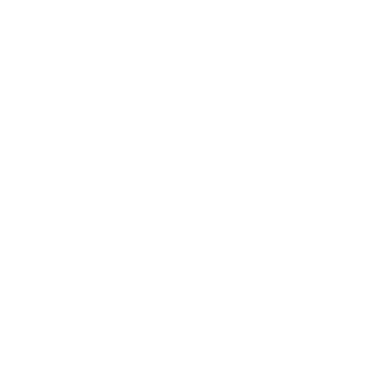

In [35]:
# Plotting the predicted segmentation (red)
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, len(scan), 2):  # Sagital view. Skip every second slice to reduce the video length
    plt.imshow(scan[i], cmap="bone")
    mask = np.ma.masked_where(segmentation[i]==0, segmentation[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")  # Use autumn colormap to get red segmentation 
    
    plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [36]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


RuntimeError: Requested MovieWriter (ffmpeg) not available